In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd
import torch.optim as optim
from torch.autograd import Variable
import time
from collections import namedtuple
from torch.distributions import Categorical
from typing import NamedTuple, List
import pandas as pd
from tqdm.notebook import tqdm

## Environment Class

In [2]:
class FoodItem(NamedTuple):
    calories: float
    carbs: float
    fats: float
    protein: float

In [3]:
class FoodEnv:
    """
    A class representing an environment for a food consumption task.

    Parameters
    ----------
    file_path : str
        The path to the CSV file containing the food data.

    Attributes
    ----------
    file_path : str
        The path to the CSV file containing the food data.
    food_df : pandas.DataFrame
        The DataFrame containing the food data.
    num_items : int
        The number of items in the food data.
    Calories : list of float
        The list of calorie values for the items.
    Protein : list of float
        The list of protein values for the items.
    Fat : list of float
        The list of fat values for the items.
    Carbs : list of float
        The list of carbohydrate values for the items.
    item_list : list of str
        The list of item names.
    food_list : dict of int to FoodItem
        A dictionary mapping item indices to [FoodItem](cci:2://c:/Myfiles/CNSlab/Apetite Control/2024/July/03_07_2024/foodenv.py:18:0-22:18) objects.
    targets : FoodItem
        The target food values.
    human_state : list of float
        The current state of the human.
    food_item_sample : int
        The index of the current food item.
    actions : list of str
        The list of possible actions.
    observations : list of str
        The list of possible observations.
    action_space : int
        The size of the action space.
    observation_space : int
        The size of the observation space.

    Methods
    -------
    create_food()
        Create the `food_list` dictionary.
    target_vals()
        Set the `targets` attribute to the target food values.
    reset()
        Reset the environment to its initial state.
    step(action)
        Take a step in the environment.
    reward_fun(curr_human_state, next_human_state)
        Calculate the reward for a transition.
    """
    def __init__(self,file_path):
        
        self.file_path = file_path
        self.food_df = pd.read_csv(file_path, header=0)
        self.num_items = len(self.food_df)
        self.Calories = list(self.food_df['Calories'])
        self.Protein = list(self.food_df['Protein'])
        self.Fat = list(self.food_df['Fat'])
        self.Carbs = list(self.food_df['Carbs'])
        self.item_list= list(self.food_df['Food'])

        self.decay = np.array([random.uniform(0.5, 0.9) for _ in range(4)])
        
        self.create_food()
        self.target_vals()
        self.reset()

        # self.actions = ['eat', 'donot eat']
        self.observations = ['calories','carbs', 'fats', 'protein']
        self.action_space = 2 # Discrete
        self.observation_space = 4 # continuous space
        
    def create_food(self):
        self.food_list = {}
        for i in range(self.num_items):
            self.food_list[i] = FoodItem(self.Calories[i], self.Carbs[i], self.Fat[i], self.Protein[i])

    def target_vals(self):
        self.targets = FoodItem(1500,60,90,145)
    
    def step(self, action): # action is to eat or not eat
        assert action in [0,1], "Invalid action chosen" 

        curr_state = self.state
        food_attributes = self.food_list[self.state[-1]]
        if(action == 0):
            food_attributes = FoodItem(0, 0, 0, 0) # empty food
        
        next_state = self.decay*curr_state[:-1] # decay the nutrition status, last element is the food item
        next_state = [sum(nutritions) for nutritions in zip(curr_state[:-1], food_attributes)] # Picking the action and calculating the next human_state
        
        random_food = np.random.choice(self.num_items) # random food item
        next_state.append(random_food) # random food item

        # Calculating the reward
        reward, done = self.reward_fun(curr_state, next_state)
        self.state = next_state

        return self.state, reward, done

    def reward_fun(self, curr_state, next_state):
        curr_dist = np.sqrt(sum([sum(nutritions)**2 for nutritions in zip(np.array(curr_state), -1 * np.array(self.targets))]))
        next_dist = np.sqrt(sum([sum(nutritions)**2 for nutritions in zip(np.array(next_state), -1 * np.array(self.targets))]))

        if next_dist <= 200:
            done = True
        else:
            done = False

        reward = curr_dist - next_dist
        return reward, done

    def reset(self):
        self.state = [0,0,0,0]
        self.state.append(np.random.choice(self.num_items))
        return self.state

## ACTOR CRITIC NN

In [4]:
class Policy(nn.Module):
    """
    A class representing a policy network for a food consumption task.

    Parameters
    ----------
    num_states : int, optional
        The number of state variables in the environment, by default 4.
    num_actions : int, optional
        The number of possible actions in the environment, by default 10.
    hidden_size : int, optional
        The size of the hidden layer in the network, by default 128.

    Attributes
    ----------
    num_states : int
        The number of state variables in the environment.
    num_actions : int
        The number of possible actions in the environment.
    hidden_size : int
        The size of the hidden layer in the network.
    actor : torch.nn.Sequential
        The actor network that predicts the probability of taking each action given the current state.
    critic : torch.nn.Sequential
        The critic network that predicts the value of the current state.

    Methods
    -------
    forward(x)
        Forward pass of the network.
    """
    def __init__(self, 
                 num_states = 5, 
                 num_actions = 2, 
                 hidden_size = 128):
        super(Policy, self).__init__()
        self.num_states = num_states
        self.num_actions = num_actions
        self.hidden_size = hidden_size
        
        self.actor = nn.Sequential(nn.Linear(self.num_states,self.hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(self.hidden_size, self.num_actions),
                                   nn.Softmax(dim = -1))
        self.critic = nn.Sequential(nn.Linear(self.num_states,self.hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(self.hidden_size, 1))

   

    def forward(self,x):
        action_probs = self.actor(x)
        val = self.critic(x)
        return action_probs, val

## Action selection policy

In [5]:
def choose_action(probs):
    """
    Choose an action based on the given probability distribution.

    Parameters
    ----------
    probs : torch.Tensor
        The probability distribution over actions.

    Returns
    -------
    action : int
        The chosen action.
    log_prob : torch.Tensor
        The log probability of the chosen action.
    """
    dist = Categorical(probs)
    action = dist.sample()
    return action.item(), dist.log_prob(action)

## Generate Episode (REINFORCE WITH BASELINE)

In [6]:
data = namedtuple('env_data',['curr_state', 'action','reward','next_state','action_probs','log_probs','value'])

def generate_episode(env,policy):
    """
    Generate a single episode of the environment.

    Parameters
    ----------
    env : FoodEnv
        The environment to generate the episode from.
    policy : Policy
        The policy to use to select actions.

    Returns
    -------
    episode_memory : deque of env_data
        The sequence of states, actions, rewards, and next states in the episode.
    """
    memory_deque_perep = deque(maxlen = 500)
    env.reset()
    curr_state = env.state
    done = False
    i = 0
    while not done:
        action_probs, vals = policy(torch.tensor(curr_state, dtype = torch.float32))
        
        action, log_prob = choose_action(action_probs)
        next_state, reward, done = env.step(action)
        # print(next_state, reward, done)
        memory_deque_perep.append(data(curr_state, action, reward, next_state, action_probs, log_prob,vals))
        curr_state = next_state
        i += 1
        if i >=500:
            break
    return memory_deque_perep
        

## REINFORCE (MC ACTOR CRITIC)

In [7]:
def reinforce(env, policy, num_episodes,gamma, optimizer):
    """
    Train a policy using reinforcement learning.

    Parameters
    ----------
    env : FoodEnv
        The environment to train the policy in.
    policy : Policy
        The policy to train.
    num_episodes : int
        The number of episodes to train the policy over.
    gamma : float
        The discount factor to use for future rewards.
    optimizer : torch.optim.Optimizer
        The optimizer to use to update the policy parameters.

    Returns
    -------
    reward_monitor : list of float
        The average return of each episode.
    num_steps_monitor : list of int
        The number of steps taken in each episode.
    """    
    reward_monitor = []
    num_steps_monitor = []
    for ep in tqdm(range(num_episodes)):
        
        # Generate episode and compute its return
        episode_memory = generate_episode(env, policy)
        episode_rew = [episode_memory[i].reward for i in range(len(episode_memory))]
        episode_curr_state = [episode_memory[i].curr_state for i in range(len(episode_memory))]
        episode_next_state = [episode_memory[i].next_state for i in range(len(episode_memory))]
        episode_value = [episode_memory[i].value for i in range(len(episode_memory))]
        
        episode_return = []
        return_value = 0
        for r in reversed(episode_rew):
            return_value += gamma*r
            episode_return.insert(0,return_value)

        
        # Compute policy loss
        policy_loss = []
        value_loss = []
        for i in range(len(episode_memory)):
            policy_loss_val = -(episode_return[i] - episode_value[i]) * episode_memory[i].log_probs
            if i == len(episode_memory) - 1:
                value_loss_val = (episode_rew[i]-episode_value[i])**2 # computes (rew + gamma * val(nextstate)-val(currstate))
            else:
                value_loss_val = (episode_rew[i]+gamma*episode_value[i+1]-episode_value[i])**2 # computes (rew + gamma * val(nextstate)-val(currstate))
            policy_loss.append(policy_loss_val)
            value_loss.append(value_loss_val)
        
        policy_loss = torch.stack(policy_loss).sum()
        value_loss = torch.stack(value_loss).sum()
        loss_tot = policy_loss + value_loss
        if ep%100 == 0:
            print(f'ep = {ep}, steps = {len(episode_memory)}, Average return = {episode_return[0]}')
        num_steps_monitor.append(len(episode_memory))
        reward_monitor.append(episode_return[0])
        optimizer.zero_grad()
        loss_tot.backward()
        optimizer.step()
    
    return reward_monitor, num_steps_monitor

In [8]:
# #torch.manual_seed(100)
# model = Policy(num_states = 4,
#                num_actions = 10,
#                hidden_size = 128)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
# env = FoodEnv('foods.csv')

## Average accross 5 runs

In [10]:
num_runs = 3
rew_arr_5runs = np.zeros((num_runs,1000))
steps_arr_5runs = np.zeros((num_runs,1000))

for i in tqdm(range(num_runs)):
    env = FoodEnv('foods.csv')
    model = Policy(num_states = 5,
               num_actions = 2,
               hidden_size = 256)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    reward_monitor, num_steps_monitor = reinforce(env, model, 1000, 0.99, optimizer)
    rew_arr_5runs[i] = reward_monitor
    steps_arr_5runs[i] = num_steps_monitor

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

ep = 0, steps = 7, Average return = 1340.297983719821
ep = 100, steps = 500, Average return = 64.62806892772846
ep = 200, steps = 500, Average return = 64.62806892772846


KeyboardInterrupt: 

(-500.0, 2000.0)

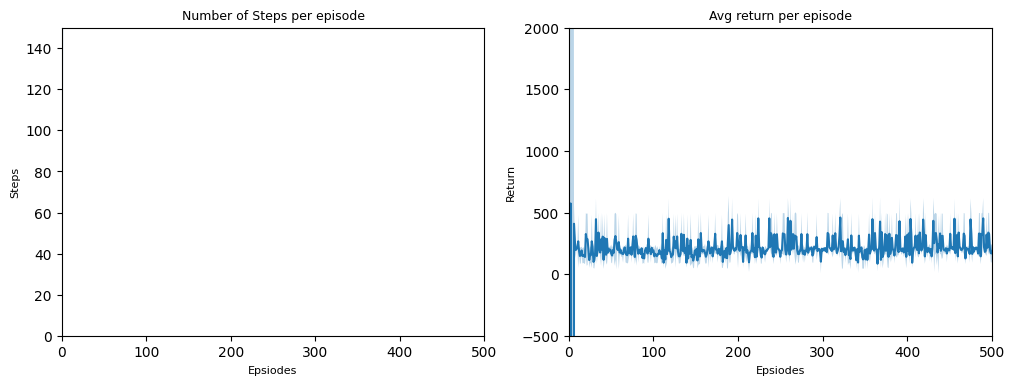

In [ ]:
mean_rew = np.mean(np.array(rew_arr_5runs), axis = 0)
mean_steps = np.mean(np.array(steps_arr_5runs), axis = 0)

se_rew = np.std(np.array(rew_arr_5runs), axis = 0)
se_steps = np.std(np.array(steps_arr_5runs), axis = 0)

episodes = np.arange(1000)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(episodes, mean_steps)
plt.fill_between(episodes, 
                 mean_steps-se_steps, 
                 mean_steps+se_steps, 
                 alpha = 0.3)
plt.xlabel('Epsiodes', fontsize = 8)
plt.ylabel('Steps', fontsize = 8)
plt.title('Number of Steps per episode',fontsize = 9)
plt.xlim(0,500)
plt.ylim(0,150)

plt.subplot(122)
plt.plot(episodes, mean_rew)
plt.fill_between(episodes, 
                 mean_rew-se_rew, 
                 mean_rew+se_rew, 
                 alpha = 0.3)
plt.xlabel('Epsiodes', fontsize = 8)
plt.ylabel('Return', fontsize = 8)
plt.title('Avg return per episode',fontsize = 9)
plt.xlim(0,500)
plt.ylim(-500,2000)